<a href="https://colab.research.google.com/github/surekhag28/ComputerVision/blob/main/FashionMNISTClassifier/fashion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
 
import torch
import torchvision
from torch.utils.data import sampler
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import torch.nn as nn
 
 
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)
 
num_epochs=10
NUM_TRAIN = 50000

cuda


In [4]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(28,padding=4),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])
 
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

In [5]:
train_data = datasets.FashionMNIST('F_MNIST_data/',download=True,train=True,transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,
                                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
 
val_data = datasets.FashionMNIST('F_MNIST_data/',download=True,train=True,transform=train_transform)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=32,
                                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,60000)))
 
test_data = datasets.FashionMNIST('F_MNIST_data/',download=True,train=False,transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=False)

Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet,self).__init__()
        self.layer1 = nn.Sequential(
                    nn.Conv2d(1,32,kernel_size=5,stride=1,padding=2),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32,32,kernel_size=5,stride=1,padding=2),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2,stride=2)
                )
        
        self.layer2 = nn.Sequential(
                    nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(kernel_size=2,stride=2)
                )
        
        self.layer3 = nn.Sequential(
                    nn.Conv2d(64,128,kernel_size=5,stride=1,padding=2),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(128),
                    nn.MaxPool2d(kernel_size=3,stride=2)
                )
        
        self.fc1 = nn.Linear(128*3*3,1024)
        self.relu = nn.ReLU()
        self.batch = nn.BatchNorm1d(1024)
        self.fc2  = nn.Linear(1024,10)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(out.size(0),-1)
        out = self.relu(self.batch(self.fc1(out)))
        out = self.fc2(out)
        return out

In [17]:
model = FashionNet()
model=model.to(dev)

In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.005,betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [19]:
total_step = len(train_loader)
train_accs,train_losses,val_accs,val_losses=[],[],[],[]

In [20]:
def train_eval_model():
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        for images,labels in train_loader:
            images = images.to(dev)
            labels = labels.to(dev)
 
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
 
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            # Track the accuracy
 
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc += float(correct) / float(total)
        else:
            with torch.no_grad():
                model.eval()
                for images,labels in val_loader:
                    images = images.to(dev)
                    labels = labels.to(dev)
 
                    val_out = model(images)
                    loss = criterion(val_out, labels)
                    val_loss += loss.item()
 
                    total = labels.size(0)
                    _, predicted = torch.max(val_out.data, 1)
                    correct = (predicted == labels).sum().item()
                    val_acc += float(correct) / float(total)
            model.train()
 
        print("Epoch: {}/{}.. ".format(epoch, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader)),
              "Training Accuracy: {: .3f}.. ".format(train_acc/len(train_loader)*100),
              "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)*100))
 
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accs.append(train_acc/len(train_loader)*100)
        val_accs.append(val_acc/len(val_loader)*100)

In [21]:
train_eval_model()

Epoch: 0/10..  Training Loss: 0.608..  Validation Loss: 0.406..  Training Accuracy:  77.525..  Validation Accuracy: 85.104
Epoch: 1/10..  Training Loss: 0.388..  Validation Loss: 0.336..  Training Accuracy:  85.851..  Validation Accuracy: 87.440
Epoch: 2/10..  Training Loss: 0.340..  Validation Loss: 0.309..  Training Accuracy:  87.468..  Validation Accuracy: 88.468
Epoch: 3/10..  Training Loss: 0.308..  Validation Loss: 0.299..  Training Accuracy:  88.570..  Validation Accuracy: 88.638
Epoch: 4/10..  Training Loss: 0.287..  Validation Loss: 0.261..  Training Accuracy:  89.405..  Validation Accuracy: 90.455
Epoch: 5/10..  Training Loss: 0.270..  Validation Loss: 0.274..  Training Accuracy:  90.145..  Validation Accuracy: 89.796
Epoch: 6/10..  Training Loss: 0.260..  Validation Loss: 0.259..  Training Accuracy:  90.425..  Validation Accuracy: 90.096
Epoch: 7/10..  Training Loss: 0.249..  Validation Loss: 0.261..  Training Accuracy:  90.939..  Validation Accuracy: 90.246
Epoch: 8/10..  T

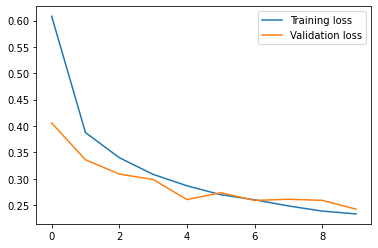

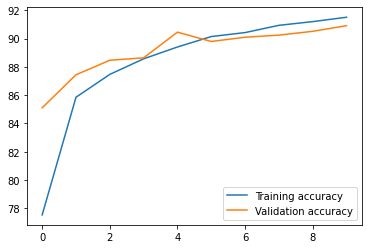

In [22]:
plt.figure()
plt.plot(train_losses,label="Training loss")
plt.plot(val_losses,label="Validation loss")
plt.legend()
plt.show()
 
 
plt.figure()
plt.plot(train_accs,label="Training accuracy")
plt.plot(val_accs,label="Validation accuracy")
plt.legend()
plt.show()

In [23]:
def test_model():
    model.eval()
    correct =0
    total=0
    
    with torch.no_grad():
        
        for images,labels in test_loader:
            images = images.to(dev)
            labels = labels.to(dev)
            
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    print("Test accuracy of the model on the 10000 test images: {}%".format(100 * correct/total))

In [24]:
test_model()

Test accuracy of the model on the 10000 test images: 92.02%
